# Una semplice implementazione di un classificatore con un layer nascosto ("_multilayer perceptron_")
Luca Mari, marzo 2023

Un classificatore per l'"hello world" delle reti neurali, il dataset mnist.  
Ispirato da https://towardsdatascience.com/mnist-handwritten-digits-classification-from-scratch-using-python-numpy-b08e401c4dab.

Costruiamo la classe con tutti i metodi per costruire, addestrare e usare la rete (i metodi il cui nome comincia con "_" sono di servizio, e non è previsto che siano chiamati direttamente).

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import requests, gzip, os

path='./data'
web_path = 'http://yann.lecun.com/exdb/mnist'

class MPerceptron:
    def __init__(self, load_pretrained:bool=False, predictable:bool=False, log:bool=True):
        if load_pretrained:
            self.load(log)
        else:
            self.c01 = self._init_connections(28 * 28, 128, predictable)
            self.c12 = self._init_connections(128, 10, predictable)
        self.x_train, self.y_train = 0, 0
        self.x_test, self.y_test = 0, 0

    def train(self, epochs=1000, size:int=128, lr:float=0.001, save:bool=False, predicatable:bool=False, log:bool=True):
        if type(self.x_train) == int: self.get_training_set(log)
        if log: print(f'\n*** Training in {epochs} fasi di {size} immagini ciascuna ***\nFase\tAccuratezza')
        data_val = self.x_train.reshape((-1, 28 * 28)) # type: ignore
        for i in range(epochs):
            x, y = self._sample(self.x_train, self.y_train, size, predicatable)
            _, update_l1, update_l2 = self._forward_backward_pass(x, y)
            self.c01 -= lr * update_l1
            self.c12 -= lr * update_l2
            if log and i % 500 == 0:
                classified = self.classify(data_val)
                print(f'{i}\t{self.eval_accuracy(classified):.1f}')
        if save: self.save(force=True, log=log)

    def test(self, size:int=10, predictable:bool=False, log:bool=True):
        if type(self.x_test) == int: self.get_test_set(log)
        if log: print(f'\n*** Test di {size} immagini ***\nIndice\tClass\tCorr')
        x, y = self._sample(self.x_test, self.y_test, size=size, predictable=predictable)
        classified = self.classify(x)
        accuracy = 100 * (classified == y).mean()
        wrong_indexes, wrong_classes = [], []
        for i in range(size):
            if classified[i] != y[i]:
                wrong_indexes.append(i)
                wrong_classes.append(classified[i])
                if log: print(f'{i}\t{classified[i]}\t{y[i]}')
        if log: print(f'\nAccuratezza: {accuracy:.1f}%')
        return x, y, wrong_indexes, wrong_classes, accuracy

    def classify(self, x): # use the trained net to classify 
        x_l1 = self._sigmoid(x.dot(self.c01))
        x_l2 = x_l1.dot(self.c12)
        return np.argmax(self._softmax(x_l2), axis=1)

    def eval_accuracy(self, data):
        return 100 * (data == self.y_train).mean()

    def get_training_set(self, log:bool=True): # get the dataset
        self.x_train = self._fetch(os.path.join(web_path, 'train-images-idx3-ubyte.gz'), 'x_train', log)[0x10:].reshape((-1, 28, 28))
        self.y_train = self._fetch(os.path.join(web_path, 'train-labels-idx1-ubyte.gz'), 'y_train', log)[8:]

    def get_test_set(self, log:bool=True): # get the dataset
        self.x_test = self._fetch(os.path.join(web_path, 't10k-images-idx3-ubyte.gz'), 'x_test', log)[0x10:].reshape((-1, 28 * 28))
        self.y_test = self._fetch(os.path.join(web_path, 't10k-labels-idx1-ubyte.gz'), 'y_test', log)[8:]

    def save(self, force:bool=False, log:bool=True):
        fp = os.path.join(path, 'trained')
        if not os.path.isfile(fp) or force:
            with open(fp, "wb") as f:
                np.savez_compressed(f, self.c01, self.c12)
            if log: print('Modello salvato.')

    def load(self, log:bool=True):
        fp = os.path.join(path, 'trained')
        with open(fp, "rb") as f:
            npzfile = np.load(f)
            self.c01 = npzfile['arr_0']
            self.c12 = npzfile['arr_1']
        if log: print('Modello caricato.')

    def show_wrongly_classified(self, x, y, wrong_indexes, wrong_classes, max_show:int=10):
        if len(wrong_indexes) == 0:
            print('Nulla da mostrare...')
            return
        plt.figure(figsize=(15, 15))
        if len(wrong_indexes) > max_show: wrong_indexes = wrong_indexes[:max_show]
        for i, j in enumerate(wrong_indexes):
            array = x[j].reshape((28, 28))
            ax = plt.subplot(5, 10, i+1)
            ax.set_title(f'{j}: {wrong_classes[i]} -> {y[j]}', {'color':'w'})
            ax.imshow(array, cmap='gray_r')
        plt.tight_layout()


    def _fetch(self, url:str, name:str, log:bool=True): # get data
        fp = os.path.join(path, name)
        if os.path.isfile(fp):
            if log: print('Dati letti localmente')
            with open(fp, "rb") as f:
                data = f.read()
        else:
            if log: print('Dati letti del web')
            with open(fp, "wb") as f:
                data = requests.get(url).content
                f.write(data)
        return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

    def _init_connections(self, x:int, y:int, predictable=True): # create and randomly init the connections between two layers
        if predictable: np.random.seed(0)
        else: np.random.seed()
        layer = np.random.uniform(-1., 1., size=(x, y)) / np.sqrt(x * y)
        return layer.astype(np.float32)

    def _sigmoid(self, x): # sigmoid function
        return 1 / (np.exp(-x) + 1)    

    def _d_sigmoid(self, x): # derivative of sigmoid
        return (np.exp(-x)) / ((np.exp(-x) + 1)**2)

    def _softmax(self, x): # softmax function
        y = np.exp(x - x.max())
        return y / np.sum(y, axis=0)

    def _d_softmax(self, x): # derivative of softmax
        y = np.exp(x - x.max())
        return y / np.sum(y, axis=0) * (1 - y / np.sum(y, axis=0))

    def _sample(self, x_data, y_data, size:int=10, predictable:bool=False):
        if predictable: np.random.seed(0)
        else: np.random.seed()
        indexes = np.random.randint(0, x_data.shape[0], size=size)
        x = x_data[indexes].reshape((-1, 28 * 28))
        y = y_data[indexes]
        return x, y

    def _forward_backward_pass(self, x, y): # forward and backward pass for training
        targets = np.zeros((len(y),10), np.float32) # labels as binary vectors (1 at the right value, 0 everywhere else)
        targets[range(targets.shape[0]), y] = 1
        x_l1 = x.dot(self.c01) # forward pass
        x_sigmoid = self._sigmoid(x_l1)
        x_l2 = x_sigmoid.dot(self.c12)
        out = self._softmax(x_l2)
        error = 2 * (out - targets) / out.shape[0] * self._d_softmax(x_l2)
        update_l2 = x_sigmoid.T @ error # (rem: x.T is trasposed x; x @ y is matrix multiplication of x and y)
        error = (self.c12.dot(error.T)).T * self._d_sigmoid(x_l1)
        update_l1 = x.T @ error
        return out, update_l1, update_l2

Data questa classe, è semplice ora costruire una rete, addestrarla e metterla alla prova.

Dati letti localmente
Dati letti localmente

*** Training in 1000 fasi di 100 immagini ciascuna ***
Fase	Accuratezza
0	10.2
500	65.2
Dati letti localmente
Dati letti localmente

*** Test di 50 immagini ***
Indice	Class	Corr
2	1	2
4	6	3
8	4	9
10	1	8
16	0	5
28	9	5
30	1	5
31	8	3
33	4	5
38	4	9
41	1	8
42	3	5
46	6	5
48	1	8

Accuratezza: 72.0%


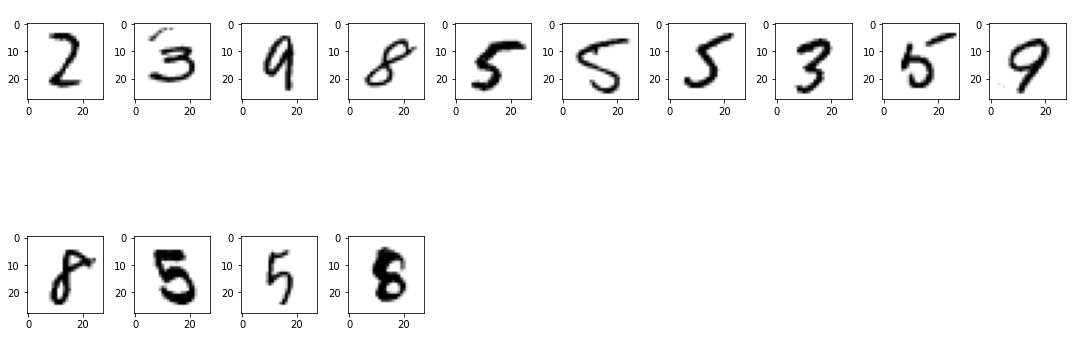

In [53]:
mperceptron = MPerceptron(load_pretrained=False)
mperceptron.train(epochs=1000, size=100, save=False)
x, y, wi, wc, a = mperceptron.test(size=50)
mperceptron.show_wrongly_classified(x, y, wi, wc, max_show=30)
